In [27]:
!python -V

Python 3.9.13


## TOY Problem: Predict the Duration of a NYC taxi ride.
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import pickle

In [124]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')  # Backend is sqlite

mlflow.set_experiment('taxi-duration-pred') # Creating Or Searching the existing experiment


2022/11/14 10:15:35 INFO mlflow.tracking.fluent: Experiment with name 'taxi-duration-pred' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/5', creation_time=1668388535641, experiment_id='5', last_update_time=1668388535641, lifecycle_stage='active', name='taxi-duration-pred', tags={}>

In [125]:

def read_dataframe(filename):

    df = pd.read_parquet(filename)
    # df_feb = pd.read_parquet('./data/green_tripdata_2021-02.parquet')
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df


In [126]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet') # Jan data as Train
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet') # Feb data as validation


In [127]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [128]:
len(df_train), len(df_val)


(73908, 61921)

In [129]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [130]:
# categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']
target = 'duration'

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = df_train[target].values


val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val[target].values


# Without MLFLOW


# Training

In [131]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

2022/11/14 10:16:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9f51f428b82d4ad88b5679a3827309a5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


7.758715206462274

/var/folders/29/yfhyl7c535516fg5k9753d3497st3t/T/ipykernel_8267/611476406.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='predict')
/var/folders/29/yfhyl7c535516fg5k9753d3497st3t/T/ipykernel_8267/611476406.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='real'

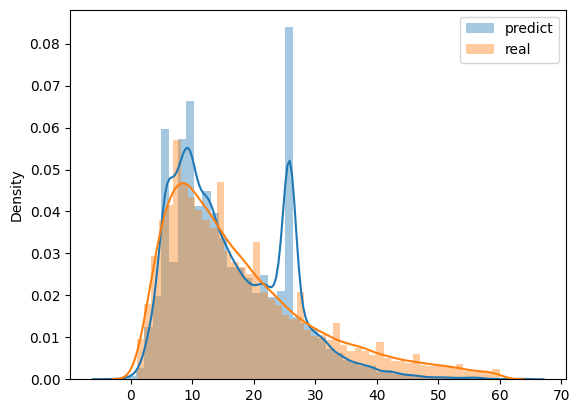

In [132]:
sns.distplot(y_pred, label='predict')
sns.distplot(y_val, label='real')

plt.legend()

# Save model

In [133]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [134]:
r = Ridge()
r.fit(X_train, y_train)
y_pred = r.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

2022/11/14 10:18:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '47f25b177d1d466b9cfcc8441bf01f68', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


11.342603943250333

In [135]:
# Without MLFLOW

lr = Lasso(alpha = 0.1)  # 0.001, 0.0001 ....

lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

2022/11/14 10:19:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1561db2fbd5d426ea0c29831537baa74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


12.143233939663894

# with ML FLOW 

In [137]:
# With MLFLOW

with mlflow.start_run(): # Starting Track..
    # Everything inside with will be associated with current run

    # Creating tag/cols
    mlflow.set_tag("developer", "Bert")


    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)


###  Hyper params tuning to the notebook
###  Compare multiple runs in MLflow
###  Select the best one
###  Model Autolog feature of MLflow

In [138]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [139]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [140]:
def objective(params): # params = hyper params

    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [141]:
### Defining 
### Range of hyper params

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),  # [4 ~ 100]
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # [exp(-3) ~ exp(0)] = [0.05 ~ 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1), 
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest,
    max_evals=8, 
    trials=Trials()
) 

[10:23:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.62693                         
[1]	validation-rmse:12.04356                         
[2]	validation-rmse:9.80972                          
[3]	validation-rmse:8.47199                          
[4]	validation-rmse:7.69153                          
[5]	validation-rmse:7.24059                          
[6]	validation-rmse:6.98012                          
[7]	validation-rmse:6.82387                          
[8]	validation-rmse:6.72748                          
[9]	validation-rmse:6.66478                          
[10]	validation-rmse:6.62603                         
[11]	validation-rmse:6.59980                         
[12]	validation-rmse:6.57916                         
[13]	validation-rmse:6.56640                         
[14]	validation-rmse:6.55795 

Select the best run: Lowest rmse, collect the parameter values from MLflow

In [142]:
### Select the best one: Best params values from MLflow

params = { 
    "learning_rate":	    0.40474130040210793,
    "max_depth"	:           83,
    "min_child_weight" :	3.351886673841718,
    "objective" :	        "reg:linear",
    "reg_alpha":	        0.18463169345854386,
    "reg_lambda":	        0.016434886465737156,
    "seed":	42
}


mlflow.xgboost.autolog() # Automatic logging allows you to log metrics, parameters, and models without the need for explicit log statements.


booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=50,
    evals=[(valid, "validation")],
    early_stopping_rounds = 5

)

2022/11/14 11:09:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1bfcbf568bff4ba8b1093608f831ff60', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.13020
[1]	validation-rmse:10.30426
[2]	validation-rmse:8.37693
[3]	validation-rmse:7.45786
[4]	validation-rmse:7.01822
[5]	validation-rmse:6.80457
[6]	validation-rmse:6.69256
[7]	validation-rmse:6.63145
[8]	validation-rmse:6.59039
[9]	validation-rmse:6.56521
[10]	validation-rmse:6.54814
[11]	validation-rmse:6.53906
[12]	validation-rmse:6.52821
[13]	validation-rmse:6.52316
[14]	validation-rmse:6.51852
[15]	validation-rmse:6.51466
[16]	validation-rmse:6.51185
[17]	validation-rmse:6.50799
[18]	validation-rmse:6.50586
[19]	validation-rmse:6.50281
[20]	validation-rmse:6.50160
[21]	validation-rmse:6.49940
[22]	validation-rmse:6.49823
[23]	validation-rmse:6.49711
[24]	validation-rmse:6.49597
[25]	validation-rmse:6.49426
[26]	validation-rmse:6.49271
[27]	valid

![title]("img/mlManagement.jpg")


# Model Management

In [143]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = { 
         "learning_rate":	    0.40474130040210793,
        "max_depth"	:           83,
        "min_child_weight" :	3.351886673841718,
        "objective" :	        "reg:linear",
        "reg_alpha":	        0.18463169345854386,
        "reg_lambda":	        0.016434886465737156,
        "seed":	42
    }

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=50,
        evals=[(valid, 'validation')],
        early_stopping_rounds=5
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # save dict vectorizer 
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    ##############
    # Logging model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[11:15:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.13020
[1]	validation-rmse:10.30426
[2]	validation-rmse:8.37693
[3]	validation-rmse:7.45786
[4]	validation-rmse:7.01822
[5]	validation-rmse:6.80457
[6]	validation-rmse:6.69256
[7]	validation-rmse:6.63145
[8]	validation-rmse:6.59039
[9]	validation-rmse:6.56521
[10]	validation-rmse:6.54814
[11]	validation-rmse:6.53906
[12]	validation-rmse:6.52821
[13]	validation-rmse:6.52316
[14]	validation-rmse:6.51852
[15]	validation-rmse:6.51466
[16]	validation-rmse:6.51185
[17]	validation-rmse:6.50799
[18]	validation-rmse:6.50586
[19]	validation-rmse:6.50281
[20]	validation-rmse:6.50160
[21]	validation-rmse:6.49940
[22]	validation-rmse:6.49823
[23]	validation-rmse:6.49711
[24]	validation-rmse:6.49597
[25]	validation-rmse:6.49426
[26]	validation-rmse:6.49271
[27]	valid

In [145]:
logged_model = 'runs:/beb25ceff67f4334b07b716a8357417b/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



[14:55:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [146]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: beb25ceff67f4334b07b716a8357417b

In [149]:
xgboost_model = mlflow.xgboost.load_model(logged_model)


[14:58:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [150]:
xgboost_model

In [151]:
y_pred = xgboost_model.predict(valid)

In [152]:
y_pred[:10]

array([14.319082,  6.715263, 13.640292, 25.435831,  9.208342, 17.230118,
       10.356195,  9.167357,  9.294672, 21.371674], dtype=float32)

# Model Registry UI

- picture from slide here
- Register three top models
    How to choose?
    1. Duration to train
    2. Memory size 
    3. Error metrics


In [144]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

2022/11/14 11:46:26 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
/Users/iqbalahmad.kabir/opt/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Model Registry by script

In [83]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="sqlite:///mlflow.db")

In [84]:
client.list_experiments() 

/var/folders/29/yfhyl7c535516fg5k9753d3497st3t/T/ipykernel_8267/849364539.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  client.list_experiments()


[<Experiment: artifact_location='./mlruns/0', creation_time=1667553040145, experiment_id='0', last_update_time=1667553040145, lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/2', creation_time=1667553352113, experiment_id='2', last_update_time=1667553352113, lifecycle_stage='active', name='nyc-taxi-duration-experiment', tags={}>,
 <Experiment: artifact_location='./mlruns/3', creation_time=1668045909656, experiment_id='3', last_update_time=1668045909656, lifecycle_stage='active', name='taxi-duration-prediction', tags={}>]

In [85]:
client.create_experiment(name="my-cool-experiment")

'4'

In [91]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='5',
    filter_string='',
    run_view_type= ViewType.ACTIVE_ONLY,
    max_results=10,
    order_by=['metrics.rmse ASC'] 
)
runs

[<Run: data=<RunData: metrics={'best_iteration': 49.0,
  'rmse': 6.423278733468526,
  'stopped_iteration': 49.0,
  'validation-rmse': 6.423278732361233}, params={'custom_metric': 'None',
  'early_stopping_rounds': '5',
  'learning_rate': '0.2338777434666984',
  'max_depth': '49',
  'maximize': 'None',
  'min_child_weight': '1.4656605510403544',
  'num_boost_round': '50',
  'objective': 'reg:linear',
  'reg_alpha': '0.2250405372261712',
  'reg_lambda': '0.003339254572538742',
  'seed': '42',
  'verbose_eval': 'True'}, tags={'mlflow.log-model.history': '[{"run_id": "c3fb23db78fe41928bf357bf07753c86", '
                              '"artifact_path": "model", "utc_time_created": '
                              '"2022-11-10 06:37:25.178497", "flavors": '
                              '{"python_function": {"loader_module": '
                              '"mlflow.xgboost", "python_version": "3.9.13", '
                              '"data": "model.xgb", "env": "conda.yaml"}, '
             

In [92]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: c3fb23db78fe41928bf357bf07753c86, rmse: 6.4233
run id: 20b2cbd405cf40389a96fb24fb9ec829, rmse: 6.4233
run id: 9848a5f4c1fb4776a4dedc376be5f189, rmse: 6.4352
run id: d5f17f5917f7406ba9ef6aff3abcfd4c, rmse: 6.4568
run id: d676c4dbdd6440ceafd314617c7545df, rmse: 6.4815
run id: cb7afb0460c9418b9e88c24566efdbbd, rmse: 6.6834
run id: a431a0ef13a04563ad910fcd6bfed5f6, rmse: 6.6899
run id: 0391f4aa5bad407ebac704e0a98995ad, rmse: 6.6934
run id: c298c9fdea3b4e65b687b968819c96e5, rmse: 6.7242
run id: dab883c95e5349b2a09df0ccdc5f00e0, rmse: 6.7423


In [90]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")



In [96]:
run_id = "dab883c95e5349b2a09df0ccdc5f00e0"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="GradientBoostingRegressor")



Registered model 'GradientBoostingRegressor' already exists. Creating a new version of this model...
2022/11/11 12:01:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: GradientBoostingRegressor, version 2
Created version '2' of model 'GradientBoostingRegressor'.


<ModelVersion: creation_timestamp=1668135665190, current_stage='None', description=None, last_updated_timestamp=1668135665190, name='GradientBoostingRegressor', run_id='dab883c95e5349b2a09df0ccdc5f00e0', run_link=None, source='./mlruns/3/dab883c95e5349b2a09df0ccdc5f00e0/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [100]:
client.search_registered_models()

[<RegisteredModel: creation_timestamp=1668134280086, description='', last_updated_timestamp=1668134381977, latest_versions=[<ModelVersion: creation_timestamp=1668134280132, current_stage='None', description='', last_updated_timestamp=1668134381977, name='ExtraTreeRegressor', run_id='8b573571c4cb4ffdb05b4b3f28909402', run_link='', source='./mlruns/3/8b573571c4cb4ffdb05b4b3f28909402/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='ExtraTreeRegressor', tags={}>,
 <RegisteredModel: creation_timestamp=1668134224839, description='', last_updated_timestamp=1668134224878, latest_versions=[<ModelVersion: creation_timestamp=1668134224878, current_stage='None', description='', last_updated_timestamp=1668134224878, name='GradientBoostRegressor', run_id='dab883c95e5349b2a09df0ccdc5f00e0', run_link='', source='./mlruns/3/dab883c95e5349b2a09df0ccdc5f00e0/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='Gra

In [109]:
model_name = "xgboost"
latest = client.get_latest_versions(name=model_name)

In [110]:
for version in latest:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: Staging


In [112]:
client.transition_model_version_stage(
    name=model_name,
    version=2,
    stage="Production",
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1667799323709, current_stage='Production', description='', last_updated_timestamp=1668147074860, name='xgboost', run_id='e7f4d54db93b445083fdbf85b75c97e0', run_link='', source='./mlruns/2/e7f4d54db93b445083fdbf85b75c97e0/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [121]:
def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}


df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


# todo
def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    pass

In [114]:
df_test = read_dataframe("data/green_tripdata_2021-03.parquet")


In [115]:
df_test

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-03-01 00:05:42,2021-03-01 00:14:03,N,1.0,83,129,1.0,1.56,7.50,...,0.5,0.00,0.0,None,0.3,8.80,1.0,1.0,0.0,8.350000
1,2,2021-03-01 00:21:03,2021-03-01 00:26:17,N,1.0,243,235,1.0,0.96,6.00,...,0.5,0.00,0.0,None,0.3,7.30,2.0,1.0,0.0,5.233333
2,2,2021-03-01 00:02:06,2021-03-01 00:22:26,N,1.0,75,242,1.0,9.93,28.00,...,0.5,2.00,0.0,None,0.3,31.30,1.0,1.0,0.0,20.333333
3,2,2021-03-01 00:24:03,2021-03-01 00:31:43,N,1.0,242,208,1.0,2.57,9.50,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.0,7.666667
4,1,2021-03-01 00:11:10,2021-03-01 00:14:46,N,1.0,41,151,1.0,0.80,5.00,...,0.5,1.85,0.0,None,0.3,8.15,1.0,1.0,0.0,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83822,2,2021-03-31 22:07:00,2021-03-31 22:13:00,None,NaN,41,75,NaN,1.48,8.46,...,0.0,1.44,0.0,None,0.3,10.20,NaN,NaN,NaN,6.000000
83823,2,2021-03-31 22:56:00,2021-03-31 23:13:00,None,NaN,95,95,NaN,0.09,54.25,...,0.0,0.00,0.0,None,0.3,57.30,NaN,NaN,NaN,17.000000
83824,2,2021-03-31 22:36:00,2021-03-31 22:45:00,None,NaN,95,95,NaN,0.66,8.11,...,0.0,0.00,0.0,None,0.3,8.41,NaN,NaN,NaN,9.000000
83825,2,2021-03-31 23:35:00,2021-04-01 00:00:00,None,NaN,37,14,NaN,9.58,36.83,...,0.0,0.00,0.0,None,0.3,39.88,NaN,NaN,NaN,25.000000


In [116]:
client.download_artifacts(run_id=run_id, path='preprocessor', dst_path='.')

'/Users/iqbalahmad.kabir/Downloads/Zoomcamps/03-trainingExperiment_Tracking/preprocessor'

In [119]:


with open("preprocessor/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

In [120]:
X_test = preprocess(df_test, dv)

NameError: name 'preprocess' is not defined